In [1]:
import tensorflow as tf
from tensorflow import keras as ks
import abc
import numpy as np
import matplotlib.pyplot as plt
import os
import time 
import fun.net_koopman as net

print(tf.config.list_physical_devices('GPU'))  # 确认GPU可用


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# According to https://blog.csdn.net/hxj0323/article/details/121629067
# Implement GPU memory allocation according to demand
gpu_list = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_list) > 0 :
    for gpu in gpu_list:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
else:
    print("Got no GPUs")

In [3]:

sp = 15
act_f = 'elu'

TIME_END = 5 * 60 * 60 
batch_size = 25
learning_rate = 0.0001

output_shape = 360
inputs_shape = output_shape 
z_dim = 450

h_state = int(3 * inputs_shape)
encoder_list = [inputs_shape, h_state, h_state, z_dim]
decoder_list = [z_dim, h_state, h_state, output_shape]
dx=0.08000


In [4]:

space_name = 'dKWP-s35'
MODEL_NAME_BASE = 'dKWP-s5-dt04-act_f-elu-sp-15-z-450-2024-09-07-14-54-55'
MODEL_NAME = space_name + '/' + MODEL_NAME_BASE

SAVE_PATH_ENCODER =  './models/' + MODEL_NAME + '/encoder'
SAVE_PATH_DECODER =  './models/' + MODEL_NAME + '/decoder'
SAVE_PATH_K_MATRIX =  './models/' + MODEL_NAME + '/kmatrix'

encoder = net.Mlp(encoder_list, act_fun=act_f, name='encoder')
koopman_op = net.Koopman(shape=encoder_list[-1])
decoder = net.Mlp(decoder_list, act_fun=act_f, name='decoder')

ckpt_encoder = tf.train.Checkpoint(step=tf.Variable(0), net=encoder) 
ckpt_decoder = tf.train.Checkpoint(step=tf.Variable(0), net=decoder) 
ckpt_k_matrix = tf.train.Checkpoint(step=tf.Variable(0), net=koopman_op) 

manager_encoder = tf.train.CheckpointManager(ckpt_encoder, SAVE_PATH_ENCODER, max_to_keep=3)
manager_decoder = tf.train.CheckpointManager(ckpt_decoder, SAVE_PATH_DECODER, max_to_keep=3)
manager_k_matrix = tf.train.CheckpointManager(ckpt_k_matrix, SAVE_PATH_K_MATRIX, max_to_keep=3)

ckpt_encoder.restore(manager_encoder.latest_checkpoint)
ckpt_decoder.restore(manager_decoder.latest_checkpoint)
ckpt_k_matrix.restore(manager_k_matrix.latest_checkpoint)


encoder [360, 1080, 1080, 450]
decoder [450, 1080, 1080, 360]


In [5]:

def koopman_data(encoder_, decoder_, koopman_op_, data, sp=99):
    """
    Batch calculation to reduce memory pressure
    data: shape = [N, T, N_X]
    sp : calculate the future sp steps
    """
    y_data_list = []
    for i in range(data.shape[0]):
        y_data_ = net.koopman_model(data[i:(i + 1), :, :], encoder_, decoder_, koopman_op_, sp=sp - 1)
        y_data_list.append(y_data_['x_recon_mult_shift'].numpy())
    y_data = tf.concat(y_data_list, axis=0)
    return y_data




In [6]:
def load_data(path):
    data = np.load(path + '.npy')
    hs = np.load(path + '_hs.npy')
    tp = np.load(path + '_tp.npy')
    return data, hs, tp 


In [7]:
# for test set, the gamma distribution as follow, 
# base_1 = 678
# base_33 = 677
# x_test_1 = x_test[:base_1, :, :]                  # gamma = 1
# x_test_33 = x_test[base_1:base_1+base_33, :, :]   # gamma = 3.3
# x_test_6 = x_test[base_1+base_33:, :, :]          # gamma = 6
# 0.5 < hs < 4, 5 < tp < 15.5 in test set
# for case_1, gamma = 7,   4 < hs < 6, 15.5 < tp < 16.2
# for case_2, gamma = 0.7, 6 < hs < 9, 16.2 < tp < 18.5
# for case_3, gamma = 0.7, 4 < hs < 6, 9.8  < tp < 16.2  

# path of test, case_1, case_2, case_3
path_list = ['data/kw-state35-gamma-c/kw-s35-gamma-c-test-9-7',
             'data/kw-state6-gamma7/kw-state6-gamma7',
             'data/kw-state7-gamma07/kw-state7-gamma07',
             'data/kw-state6-gamma07/test-kw-state6-gamma07_case3']
x_test, hs, tp = load_data(path=path_list[3])
y_test = koopman_data(encoder, decoder, koopman_op, x_test, sp=500)


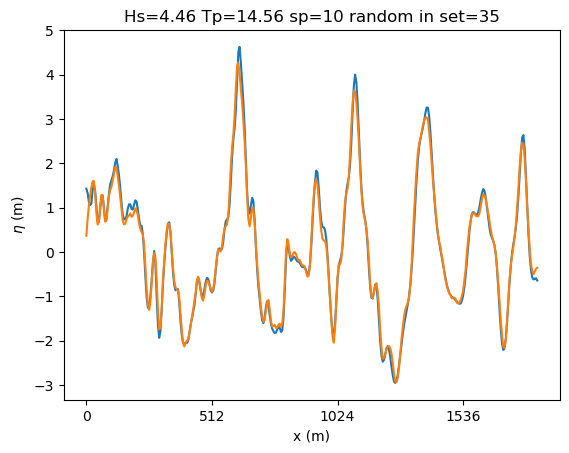

In [9]:
num_1 = np.random.randint(x_test.shape[0])
# predict the future sp steps, you can change sp to predict future sp steps
sp = 10
plt.plot(x_test[num_1, sp, :])
plt.plot(y_test[num_1, sp-1, :])
plt.title('Hs=%.2f Tp=%.2f sp=%d random in set=%d'%(hs[num_1], tp[num_1], sp, num_1))
plt.xticks([0, 100, 200, 300,], [0, 512, 1024, 1536],  )
plt.xlabel('x (m)')
plt.ylabel(r'$\eta$' + ' (m)')
plt.show()